In [1]:
import csv
import numpy as np
import os
import sys
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams.update({'font.size': 12, 'figure.max_open_warning': 0})
plt.rc("figure", dpi=100)
plt.style.use("seaborn-whitegrid")

print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

2.3.0
Num GPUs: 0


In [2]:
# Check available datasets
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'ai2_arc',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'emnist',
 'eraser_multi_rc',
 'esnli',
 'eurosat',
 'fashion_mnist

In [3]:
(train_ds, val_ds), metadata = tfds.load(
    'horses_or_humans',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /Users/ygong/tensorflow_datasets/horses_or_humans/3.0.0.incompleteTG00XS/horses_or_humans-train.tfrecord


  0%|          | 0/1027 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /Users/ygong/tensorflow_datasets/horses_or_humans/3.0.0.incompleteTG00XS/horses_or_humans-test.tfrecord


  0%|          | 0/256 [00:00<?, ? examples/s]

Dataset horses_or_humans downloaded and prepared to /Users/ygong/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

2


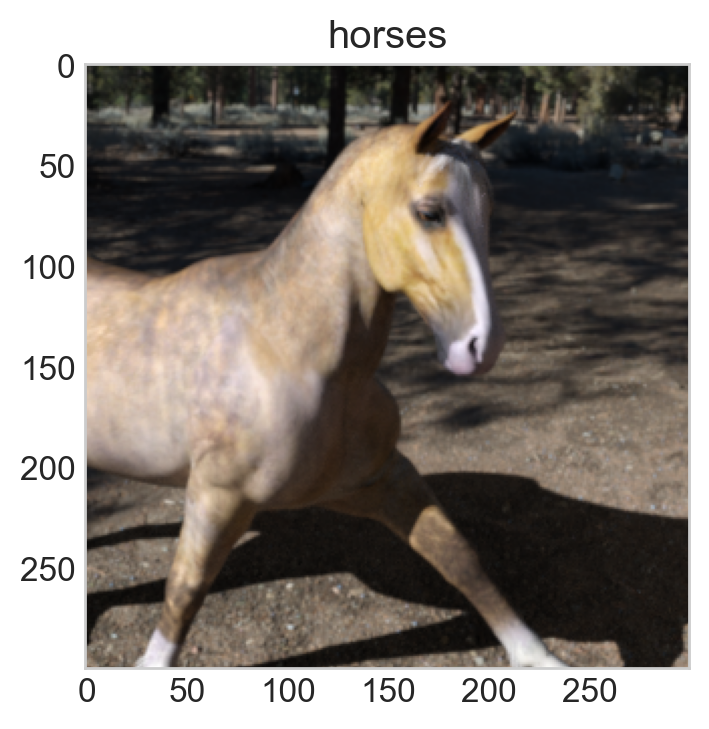

In [11]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))
plt.grid(False)

In [8]:
IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

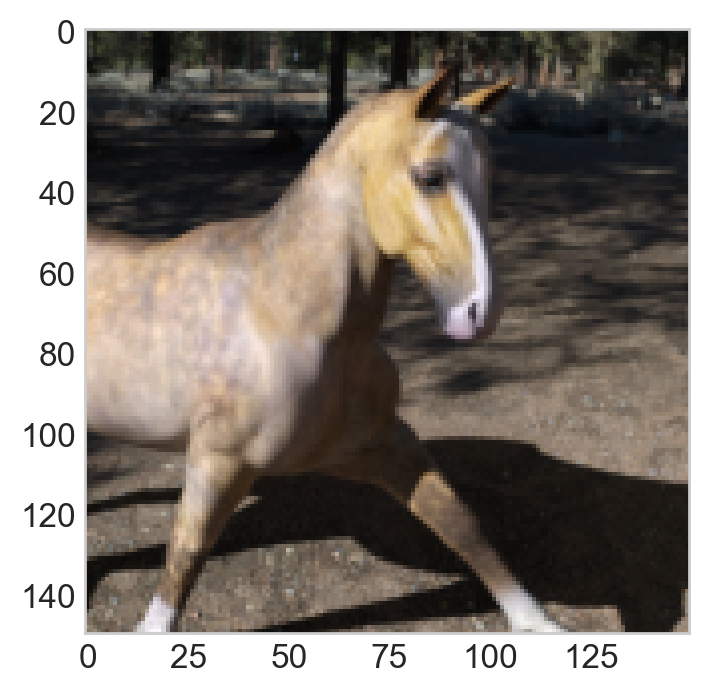

In [10]:
result = resize_and_rescale(image)
_ = plt.imshow(result)
plt.grid(False)

In [12]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.012745099 0.98921573


In [29]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2,
                                                                      0.2),
                                                        width_factor=(-0.2,
                                                                      0.2)),
    layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
])

In [15]:
# Add the image to a batch
image = tf.expand_dims(image, 0)
image.shape

TensorShape([1, 300, 300, 3])

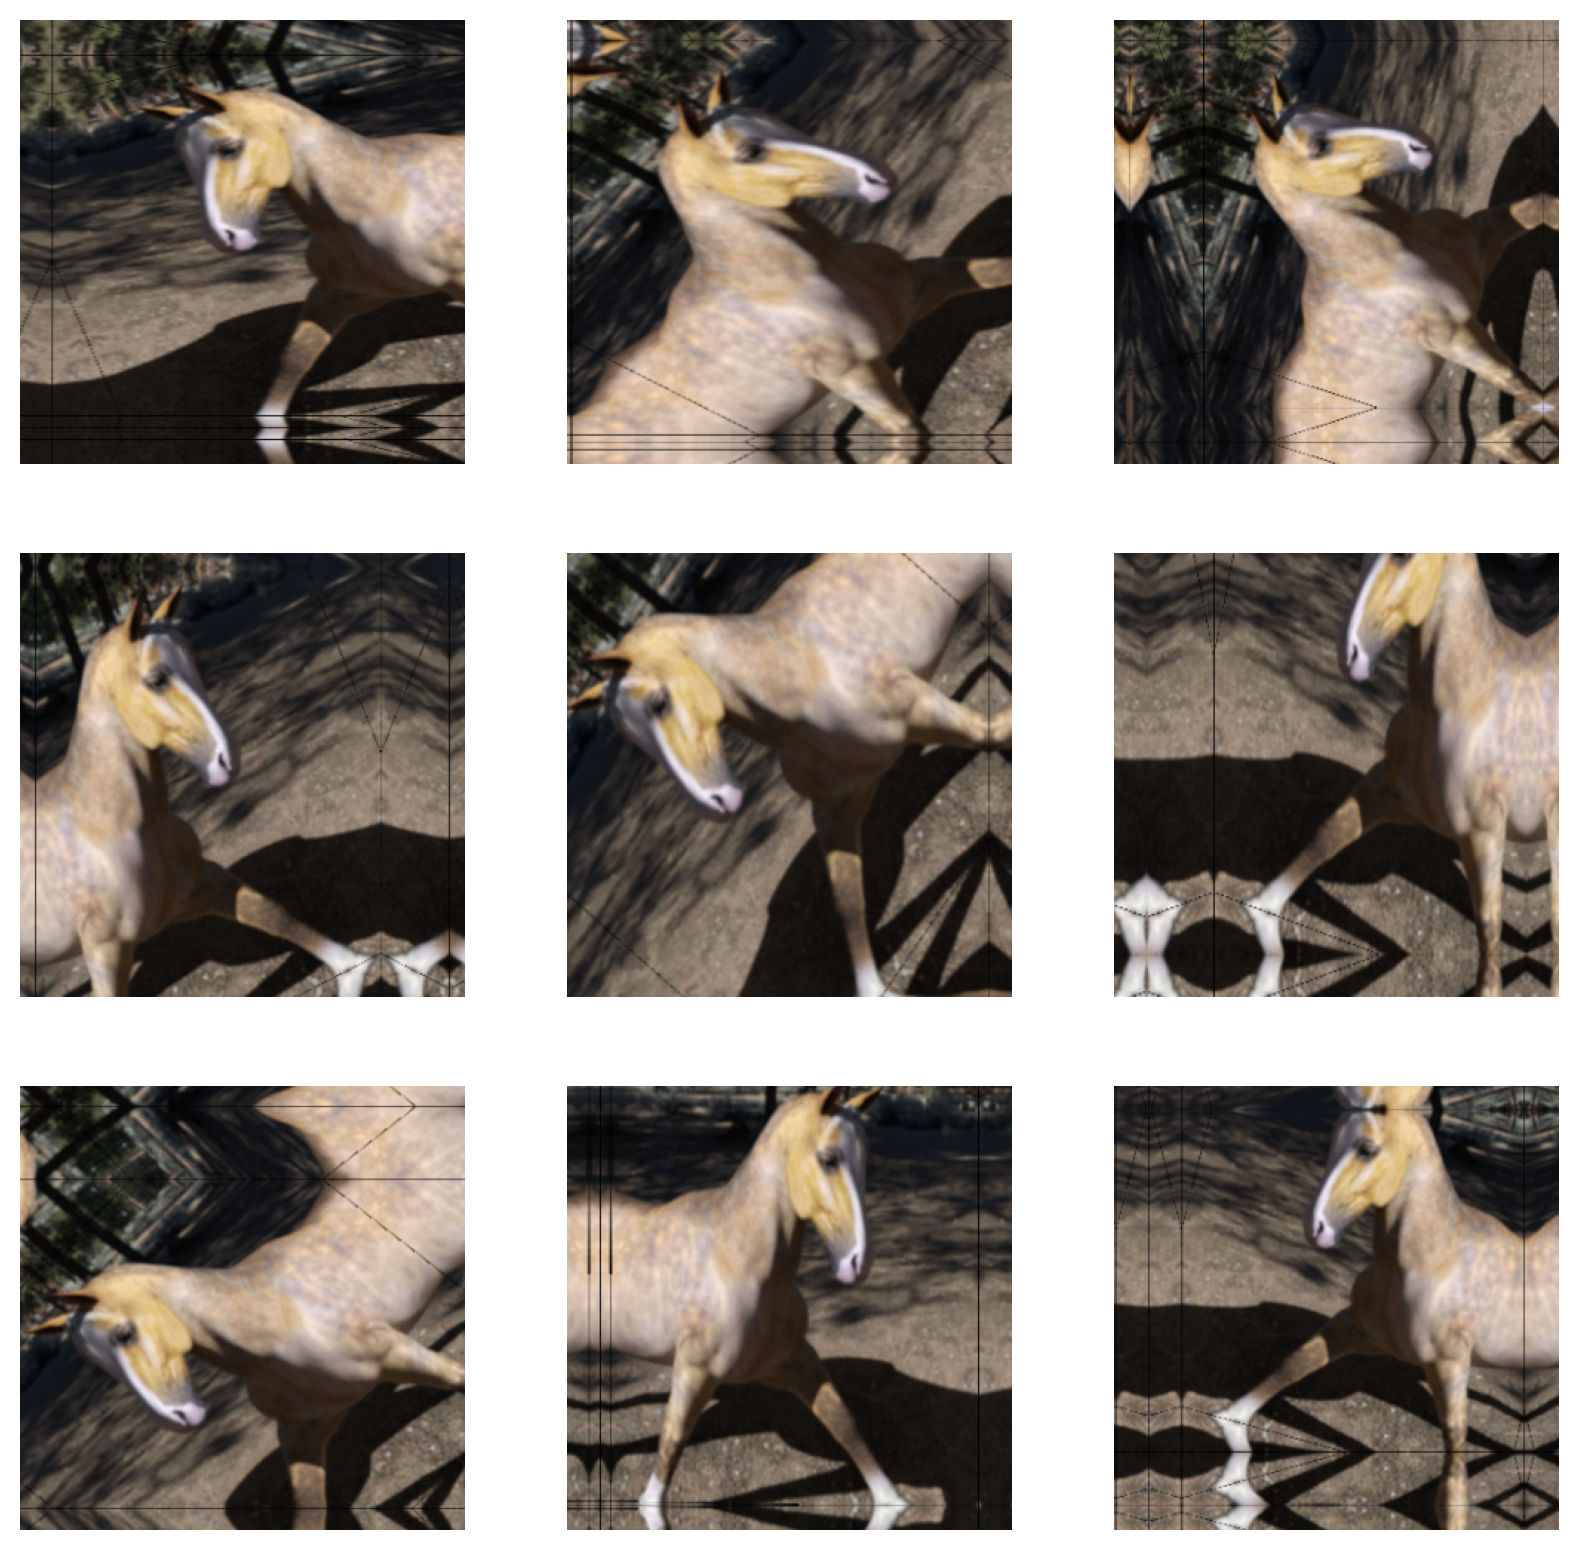

In [30]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [18]:
augmented_image.shape

TensorShape([1, 300, 300, 3])

In [175]:
def tfds_imgen(dataset, datagen, batch_size):
    """
    yield augmented data at a rate of your desired batch size
    """
    for images, labels in dataset:
        flow_ = datagen.flow(images, labels, batch_size=batch_size)
        for _ in range(batch_size):
            yield next(flow_)


SOME_MULTIPLE_OF_32 = 128

(train_ds, val_ds), info = tfds.load(name='horses_or_humans',
                                     split=['train', 'test'],
                                     batch_size=128,
                                     with_info=True,
                                     as_supervised=True)


datagen = ImageDataGenerator(...)

train_dataset = tfds_imgen(train_ds.as_numpy_iterator(),
                           datagen,
                           batch_size=64)

In [190]:
info.splits['train']

<tfds.core.SplitInfo num_examples=1027>

In [193]:
102720

102720

In [182]:
val_dataset =  tfds_imgen(val_ds.as_numpy_iterator(),
                                         datagen,
                                         batch_size=64)

In [183]:
next(val_dataset)[0].shape

(64, 300, 300, 3)

In [34]:
info.splits['test'].num_examples

256

In [ ]:
### Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale= 1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# path_inception = f"{getcwd()}/../tmp2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
# local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet') # Your Code Heredataset['test']

In [7]:
for layer in pre_trained_model.layers:
# Your Code Here
      layer.trainable = False
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________